In [135]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import scipy as sp

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 1: Визуальный поиск</h3> 
    </div>
</div>

## Пример

Скачаем датасет Caltech 101, который содержит изображения, разбитые на 101 класс. В каждом классе от 40 до 800 картинок.
Там есть котики, цветочки, кораблики и много чего еще.

http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [5]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz

--2018-08-03 13:10:34--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  1.65MB/s    in 1m 42s  

2018-08-03 13:12:17 (1.24 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



Пример:

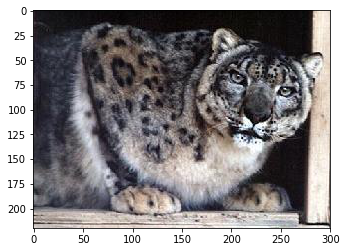

In [25]:
i = plt.imread('./101_ObjectCategories/wild_cat/image_0030.jpg')
plt.imshow(i);

__Задача__ состоит в следующем: найти $k$ изображений максимально похожих по визуальному содержанию на заданное.

__Как решать?__ 
- Можно использовать высокоуровневые признаки, полученные с помощью предобученной сверточной сети. Лучше всего подойдут сети, обученные на ImageNet. 
- Далее на основе этих признаков строится модель ближайших соседей. Для выполнения поиска необходимо:
    * Вычислить расстояние до каждого из объектов обучающей выборки
    * Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально

Примерно так это будет выглядеть, если использовать `turicreate`:

Сначала загрузим картинки

In [7]:
import turicreate as tc

reference_data = tc.image_analysis.load_images('./101_ObjectCategories')
reference_data = reference_data.add_row_number()

Unsupported image format. Supported formats are JPEG and PNG	 file: /opt/shared/SummerSchool/dl_notebooks/06. Современные нейросети/101_ObjectCategories/BACKGROUND_Google/tmp

In [ ]:
# disable GPU
tc.config.set_num_gpus(0)

Создаем модель

In [17]:
model = tc.image_similarity.create(reference_data)

Resizing images...
Performing feature extraction on resized images...
Completed  512/9144
Completed 1024/9144
Completed 1536/9144
Completed 2048/9144
Completed 2560/9144
Completed 3072/9144
Completed 3584/9144
Completed 4096/9144
Completed 4608/9144
Completed 5120/9144
Completed 5632/9144
Completed 6144/9144
Completed 6656/9144
Completed 7168/9144
Completed 7680/9144
Completed 8192/9144
Completed 8704/9144
Completed 9144/9144


<unknown>:39: DeprecationWarning: invalid escape sequence \s


Starting brute force nearest neighbors model training.

Хотим найти похожие изображения в обучающей выборке (здесь я беру изображение из обучающей выборки, но можно взять любое другое)

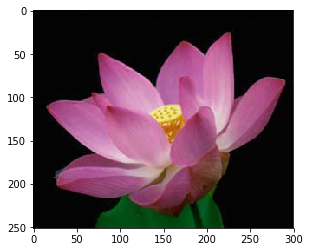

In [81]:
image_id = 6759
i = plt.imread(reference_data[image_id]['path'])
plt.imshow(i);

- Вычисляем расстояние до каждого из объектов обучающей выборки
- Отбираем $k$ объектов обучающей выборки, расстояние до которых минимально

In [92]:
query_results = model.query(reference_data[image_id:image_id+1], k=10)
query_results.head()

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0109361   | 38.592ms     |

| Done         |         | 100         | 148.97ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,6759,0.0,1
0,6729,7.652508026958864,2
0,6772,8.603170589473748,3
0,6745,8.723200226017838,4
0,8874,8.76546155232104,5
0,6782,9.819507671059249,6
0,6742,9.862097569519038,7
0,8876,10.101749075129904,8
0,6776,10.65803285109916,9
0,6765,10.763510522411774,10


Находим эти картинки в выборке

In [ ]:
similar_rows = query_results[query_results['query_label'] == 0]['reference_label']
filtered = reference_data.filter_by(similar_rows, 'id')

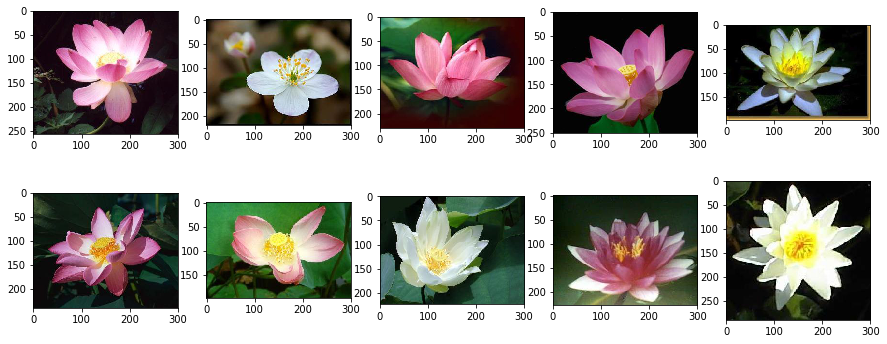

In [98]:
fig=plt.figure(figsize=(15, 6))
columns = 5
rows = 2
for i in range(columns*rows):
    img = plt.imread(filtered[i]['path'])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

__Теперь вам нужно сделать тоже самое с помощью Keras.__


## Подсказки

- Можно подсматривать в тетрадку Transfer Learning.
- Для измерения расстояния между двумя векторами нужно использовать [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html). Попробуй разные: `euclidean`, `cosine`, ..
- Попробуй разные модели `Inception`, `ResNet`, ...
- Если размерность вектора признаков слишком большая (например, `(7, 7, 1024)`), то можно использовать пулинг максимальным или средним значением (в данном примере нужно сделать пулинг `(7, 7)`, чтобы получить `(1, 1, 1024)`). 

In [134]:
from keras.applications import MobileNet, InceptionV3, InceptionResNetV2, ResNet50, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import MaxPool2D, AvgPool2D, Flatten
from keras.models import Model

### Загрузить модель без последнего FC-слоя:

In [141]:
input_shape = (224, 224, 3)

In [193]:
model = MobileNet(input_shape=input_shape, include_top=False)

# model.summary()

### Пример с пулингом:

In [137]:
model.output

<tf.Tensor 'conv_pw_13_relu_4/Minimum:0' shape=(?, 7, 7, 1024) dtype=float32>

In [138]:
x = AvgPool2D(pool_size=(7,7))(model.output)
new_model = Model(model.input, x)

new_model.output

<tf.Tensor 'average_pooling2d_6/AvgPool:0' shape=(?, 1, 1, 1024) dtype=float32>

### Как извлекать признаки:

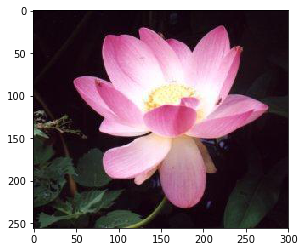

In [196]:
image = plt.imread('./101_ObjectCategories/lotus/image_0013.jpg')
plt.imshow(image);

In [197]:
image = sp.misc.imresize(image, input_shape).astype('float32')
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)

features = new_model.predict(image)
features = np.squeeze(features)

features.shape

(1024,)

In [198]:
features

array([0.37281924, 0.        , 0.37523678, ..., 0.02115398, 0.        ,
       0.33434972], dtype=float32)

### Как считать расстояние:

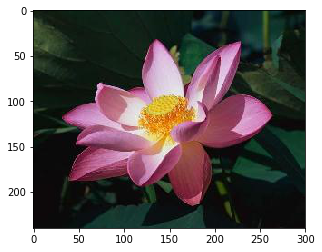

In [200]:
similar_image = plt.imread('./101_ObjectCategories/lotus/image_0056.jpg')
plt.imshow(similar_image);

In [201]:
similar_image = sp.misc.imresize(similar_image, input_shape).astype('float32')
similar_image = preprocess_input(similar_image)
similar_image = np.expand_dims(similar_image, axis=0)

similar_features = new_model.predict(similar_image)
similar_features = np.squeeze(similar_features)

sp.spatial.distance.cosine(features, similar_features)

0.2546781301498413

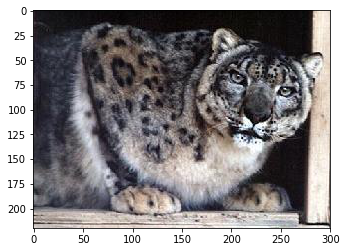

In [202]:
dissimilar_image = plt.imread('./101_ObjectCategories/wild_cat/image_0030.jpg')
plt.imshow(dissimilar_image);

In [203]:
dissimilar_image = sp.misc.imresize(dissimilar_image, input_shape).astype('float32')
dissimilar_image = preprocess_input(dissimilar_image)
dissimilar_image = np.expand_dims(dissimilar_image, axis=0)

dissimilar_features = new_model.predict(dissimilar_image)
dissimilar_features = np.squeeze(dissimilar_features)

sp.spatial.distance.cosine(features, dissimilar_features)

0.4651529788970947

Видим, что цветы ближе между собой, чем цветок и дикая кошка $(0.25 < 0.47)$

### Как читать данные

In [204]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

generator = datagen.flow_from_directory(
    directory='./101_ObjectCategories',
    target_size=(224,224),   
    batch_size=32,
    class_mode='categorical'
)

In [216]:
# get next batch
x, y = generator.next()

In [221]:
# 32 images batch
x.shape

(32, 224, 224, 3)

In [220]:
# one-hot
y.shape

(32, 102)

In [224]:
y_pred = new_model.predict_on_batch(x)
y_pred.shape

(32, 1, 1, 1024)

Сразу всю выборку:

In [229]:
# new_model.predict_generator(generator)
# new_model.fit_generator(generator, ...)

Подробнее можно почитать в статье: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Решение

Теперь у тебя есть все необходимое! Повтори пример с цветами! (А потом попробуй на других картинках)

In [101]:
# Твой код